# Exploring Basic Distributional Representations

When I started my studies in NLP, Word2Vec embeddings were already the standard for representing word types. Distributional representations based on counting the occurence of words were mentioned as precursers of Word2Vec embeddings, but we never got much hands on experience with them. In this notebook I explore basic techniques of creating such distributional representations.

In [1]:
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.linalg import svd
from typing import List, Tuple
from collections import Counter
from scipy.spatial import distance

from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet, brown

## Loading Corpora

I am using six short pieces by philosopher and logician Charles S. Peirce as my corpus.

In [2]:
file_paths = ["texts/" + file_name for file_name in ("fixation_of_belief.txt",
                                                     "how_to_make_our_ideas_clear.txt",
                                                     "the_doctrine_of_chances.txt",
                                                     "the_probability_of_induction.txt",
                                                     "the_order_of_nature.txt",
                                                     "deduction,_induction_,and_hypothesis.txt")]
corpus = ""

for path in file_paths:
    with open(path, "r", encoding="utf-8") as file:
        corpus += file.read()
        
corpus = corpus.replace("—", " ")  # fix for tokenization problem

First two sentences from Peirce's _The Fixation of Belief_

In [3]:
corpus[:243]

"Few persons care to study logic, because everybody conceives himself to be proficient enough in the art of reasoning already. But I observe that this satisfaction is limited to one's own ratiocination, and does not extend to that of other men."

## Preparing Corpus

To create distributional representations we have to prepare the corpus. The corpus is tokenized, lemmatized, and a vocabulary is created for it. This vocabulary does not include stopwords or punctuation.

First, I create a set of stopwords.

In [4]:
# nltk.download("stopwords")  # might be required if corpus is not already downloaded, same for other corpora
stop_words = set(stopwords.words("english"))
stop_words = stop_words.union(set(string.ascii_lowercase))
stop_words = stop_words.union({"doe", "'s", "ha", "wa"})

extended_punctuation = {"''", "``", "´´"}.union(set(string.punctuation))
stop_words = stop_words.union(extended_punctuation)

I create a function to lemmatize an already tokenized corpus. 

In [5]:
tag_dict= {
    "J": wordnet.ADJ,
    "V": wordnet.VERB,
    "N": wordnet.NOUN,
    "R": wordnet.ADV
}


def lemmatize_corpus(tokenized_corpus: List[str]) -> List[str]:
    lemmatizer = WordNetLemmatizer()
    tagged_corpus = nltk.pos_tag(tokenized_corpus)
    
    lemmatized_corpus = [lemmatizer.lemmatize(word, tag_dict.get(tag, wordnet.NOUN)).lower() for word, tag in tagged_corpus]
    return lemmatized_corpus

I create a function that prepares an entire corpus given as a string. This function returns a lemmatized corpus and a vocabulary (without stopwords) for that corpus. `prepare_corpus` also allows to create a vocabulary only for the `n` most common words.

In [6]:
def prepare_corpus(corpus: str, n: int = 0) -> Tuple[List[str], List[str]]:
    tokenized_corpus = word_tokenize(corpus)
    lemmatized_corpus = lemmatize_corpus(tokenized_corpus)
    
    if n == 0:
        vocab = list(set(lemmatized_corpus).difference(stop_words))
    else:
        vocab_counter = Counter(lemmatized_corpus)
        
        for sw in stop_words:
            vocab_counter[sw] = 0
            
        vocab = [w for w, _ in vocab_counter.most_common(n)]
    
    return lemmatized_corpus, vocab

## Exploration of the Corpus

Before diving into the distributional representation, it makes sense to explore the corpus a little. For example, we might want to check what the most common lemmas are.

In [7]:
prepared_corpus, vocab = prepare_corpus(corpus)
counter = Counter(prepared_corpus)
counter.most_common(10)

[(',', 2869),
 ('the', 2670),
 ('of', 2110),
 ('.', 1452),
 ('a', 1424),
 ('to', 1227),
 ('is', 987),
 ('in', 866),
 ('that', 865),
 ('and', 832)]

All of the 10 most common lemmas are stopwords, but we can also see the 10 most common content words.

In [8]:
for sw in stop_words:
    counter[sw] = 0
counter.most_common(10)

[('one', 212),
 ('would', 201),
 ('may', 168),
 ('probability', 139),
 ('fact', 134),
 ('number', 133),
 ('belief', 117),
 ('character', 106),
 ('true', 105),
 ('case', 99)]

#### Plotting the Most Common Words

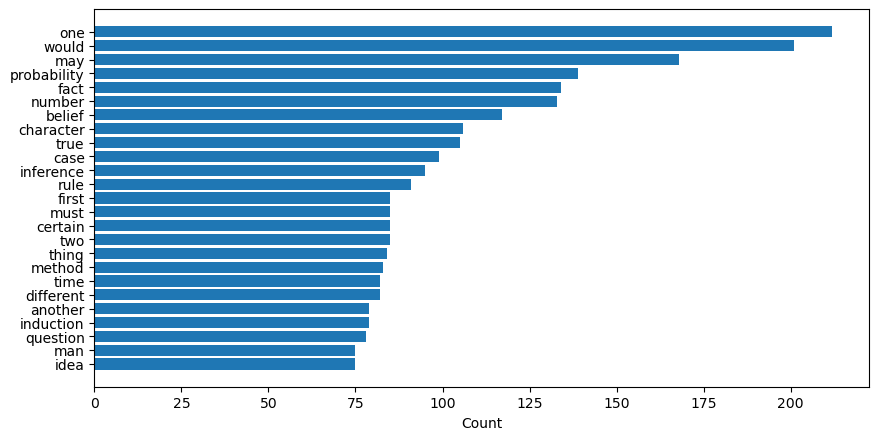

In [9]:
plt.figure(figsize=(10,5), dpi=100)

labels, values = zip(*counter.most_common(25))

indexes = np.arange(len(labels))

plt.barh(indexes, values[::-1])
plt.yticks(indexes, labels[::-1])

plt.xlabel('Count')
plt.show()

Number of all types in corpus (including stop words)

In [10]:
len(counter)

4093

Number of hapax legomena (words that occure once in the corpus)

In [11]:
sum([1 for _, c in counter.items() if c == 1])

1938

## Create Count Matrix

The core function `generate_count_matrix` creates a count matrix and a vocabulary index for that matrix. The implementation here is general for all sizes of sliding windows, but they need to be symmetric. 

In [12]:
def generate_count_matrix(processed_corpus: List[str], vocab: List[str], n: int = 2) -> Tuple[np.matrix, dict]:
    assert n > 0, "Do not use negative sizes for sliding windows"
    
    vocab_index = {token: i for i, token in enumerate(vocab)}
    count_matrix = np.zeros((len(vocab), len(vocab)))
    
    for i, token in enumerate(processed_corpus):
        if token not in vocab:
                continue
                
        index = vocab_index[token]
        
        prior_indices = [j for j in range(i-n, i) if j >= 0]
        posterior_indices = [j for j in range(i+1, i+n+1) if j < len(processed_corpus)]
        surrounding_indices =  prior_indices + posterior_indices
        
        for j in surrounding_indices:
            other_token = processed_corpus[j]
            
            if other_token not in vocab:
                continue
            
            other_index = vocab_index[other_token]
            count_matrix[index][other_index] += 1
            count_matrix[other_index][index] += 1
    
    return np.matrix(count_matrix), vocab_index

### Count Matrix for Peirce's Texts

We can now create a simple co-occurence matrix for the corpus. Here I am taking a rather large sliding window of 5 on each side, i.e. each token sees its 10 surrounding tokens.

In [13]:
count_matrix, vocab_index = generate_count_matrix(prepared_corpus, vocab, 5)
pd.DataFrame(count_matrix, index=vocab_index, columns=vocab_index)

,mentioned,impossibility,upon,inductively,untraveled,intent,ask,affirm,unfamiliar,un-b-ness,...,evolution,unrelated,wavering,denied,similarity,candour,refined,lightning,limited,exist
mentioned,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
impossibility,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
upon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
inductively,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
untraveled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
candour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
refined,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lightning,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
limited,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0


As can be seen here the initial count matrix is extremely sparse. This sparseness results from a relatively large vocabulary for a small corpus. While I picked a large window size most word types won't have tokens that meet in a window.

### Example of a Small Count Matrix
In this example I use only the 25 most common words to create a count matrix. As can be seen, this matrix is considerably denser.

In [14]:
prepared_corpus, small_vocab = prepare_corpus(corpus, 25)
small_count_matrix, small_vocab_index = generate_count_matrix(prepared_corpus, small_vocab, 5)
pd.DataFrame(small_count_matrix, index=small_vocab_index, columns=small_vocab_index)

,one,would,may,probability,fact,number,belief,character,true,case,...,two,thing,method,time,different,another,induction,question,man,idea
one,8.0,28.0,12.0,8.0,24.0,8.0,8.0,10.0,12.0,0.0,...,16.0,10.0,4.0,6.0,12.0,58.0,4.0,8.0,10.0,6.0
would,28.0,8.0,4.0,8.0,10.0,24.0,8.0,8.0,8.0,6.0,...,8.0,2.0,4.0,4.0,10.0,8.0,2.0,8.0,10.0,0.0
may,12.0,4.0,0.0,8.0,8.0,8.0,14.0,12.0,4.0,14.0,...,6.0,4.0,6.0,4.0,8.0,4.0,8.0,8.0,6.0,4.0
probability,8.0,8.0,8.0,8.0,8.0,6.0,2.0,4.0,8.0,8.0,...,20.0,4.0,2.0,0.0,6.0,8.0,2.0,8.0,0.0,10.0
fact,24.0,10.0,8.0,8.0,12.0,4.0,4.0,6.0,6.0,10.0,...,0.0,2.0,4.0,0.0,16.0,22.0,6.0,14.0,2.0,6.0
number,8.0,24.0,8.0,6.0,4.0,24.0,2.0,6.0,4.0,10.0,...,20.0,6.0,0.0,14.0,6.0,2.0,4.0,2.0,0.0,2.0
belief,8.0,8.0,14.0,2.0,4.0,2.0,16.0,0.0,8.0,0.0,...,2.0,2.0,12.0,0.0,12.0,2.0,2.0,2.0,2.0,2.0
character,10.0,8.0,12.0,4.0,6.0,6.0,0.0,8.0,4.0,4.0,...,8.0,8.0,0.0,0.0,12.0,6.0,6.0,4.0,0.0,0.0
true,12.0,8.0,4.0,8.0,6.0,4.0,8.0,4.0,20.0,8.0,...,6.0,20.0,0.0,6.0,6.0,2.0,8.0,2.0,2.0,2.0
case,0.0,6.0,14.0,8.0,10.0,10.0,0.0,4.0,8.0,8.0,...,0.0,0.0,2.0,4.0,6.0,6.0,2.0,2.0,2.0,2.0


#### Visualisation

Such a small matrix can be visualised using a heatmap.

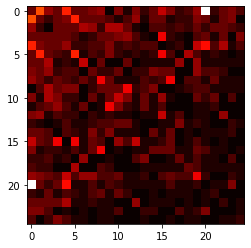

In [15]:
plt.imshow(small_count_matrix, cmap='hot', interpolation='nearest')

The following cell can be converted to code to create a count matrix for the Brown corpus. It takes quite a while to run, however, and therefore I have disabled.

## Similarity Scoring

One of the core application of vector representations is to measure the similarity between concepts. We use cosine similarity between two vectors to calculate their similarity.

In [16]:
def cosine_similarity(first_vector: np.array, second_vector: np.array) -> float:
    return 1 - distance.cosine(first_vector, second_vector)

I also create a function to extract word vectors from the count matrix.

In [17]:
def get_vector(word: str, count_matrix: np.matrix, vocab_index: dict) -> np.array:
    i = vocab_index[word]
    return np.array(count_matrix[i,:]).squeeze()

In the following cell I extract the vectors vectors for three words:
- "belief"
- "horror"
- "method"

In [18]:
b_vector, h_vector, m_vector = map(lambda w: get_vector(w, count_matrix, vocab_index), ("belief", "horror", "method"))

At the moment, our vectors have the length of the entire vocabulary (excluding stopwords)

In [19]:
b_vector.shape

(3857,)

### Sanity Check

Cosine similarity lies in the range $[-1, 1]$. A vector should have cosine similarity of 1 to itself and -1 to itself multiplied by -1.

In [20]:
cosine_similarity(b_vector, b_vector)

1.0

In [21]:
cosine_similarity(b_vector, -1*b_vector)

-1.0

Cosine similarity between "belief" and "horror".

In [22]:
cosine_similarity(b_vector, h_vector)

0.015891043154093176

Cosine similarity is a symmetric function, i.e. if we swap the two vectors we get the same result.

In [23]:
cosine_similarity(h_vector, b_vector)

0.015891043154093176

Intuitively, "belief" and "method" are more closely related than "belief" and "horror". With cosine similarity we can test this intuition.

In [24]:
cosine_similarity(b_vector, m_vector)

0.36151266252562264

In [25]:
cosine_similarity(h_vector, m_vector)

0.10048348388226758

Because the matrix is sparse, the cosine similarity often becomes 0.

In [26]:
g_vector = get_vector("german", count_matrix, vocab_index)
cosine_similarity(h_vector, g_vector)

0.0

## Calculate Pointwise Mutual Information

Mere counts lead to extremely sparse matrices and do not account for the differences in frequency between words at all. A relatively simple approach to address these issues is to use *Pointwise Mutual Information* (PMI). For the occurence of two words in the same window, PMI is defined as 

\begin{equation}
    \text{log}(\frac{\text{P}(A,B)}{\text{P}(A)*\text{P}(B)})
\end{equation}

We estimate the probabilities using frequency counts from the count matrix.

In [27]:
def pmi_calculation(count_matrix: np.matrix, smoothing: float = 0.01) -> np.matrix:
    count_array = np.array(count_matrix) + smoothing
    
    num_ngrams = count_array.sum() / 2
    all_sums = np.sum(count_array, axis=0)
    
    pmi_array = np.zeros_like(count_array)
    
    for i1, i2 in zip(*np.triu_indices_from(count_array)):
        p_ab = count_array[i1, i2] / num_ngrams
        p_a = all_sums[i1] / num_ngrams
        p_b = all_sums[i2] / num_ngrams
                
        pmi_array[i1, i2] = np.log(p_ab/(p_a*p_b))
        
    return np.matrix(np.where(pmi_array,pmi_array,pmi_array.T))

In [28]:
p_matrix = pmi_calculation(count_matrix)
pd.DataFrame(p_matrix, index=vocab_index, columns=vocab_index)

,mentioned,impossibility,upon,inductively,untraveled,intent,ask,affirm,unfamiliar,un-b-ness,...,evolution,unrelated,wavering,denied,similarity,candour,refined,lightning,limited,exist
mentioned,-0.393776,-0.720570,-3.066895,-0.588299,-0.393776,-0.349881,-1.294006,-0.514965,-0.349881,-0.552304,...,-0.393776,-0.349881,-0.393776,-0.435826,-0.623042,-0.349881,-0.435826,-0.514965,-1.345050,-1.553876
impossibility,-0.720570,-1.047363,-3.393689,4.388213,-0.720570,-0.676674,-1.620799,-0.841759,-0.676674,-0.879097,...,-0.720570,-0.676674,-0.720570,-0.762619,-0.949836,-0.676674,-0.762619,-0.841759,-1.671844,-1.880669
upon,-3.066895,-3.393689,-5.740014,-3.261418,-3.066895,-3.023000,-3.967125,-3.188084,-3.023000,-3.225423,...,-3.066895,-3.023000,-3.066895,-3.108945,-3.296161,-3.023000,-3.108945,2.115221,-4.018169,-4.226995
inductively,-0.588299,4.388213,-3.261418,-0.782821,-0.588299,-0.544403,-1.488528,-0.709488,-0.544403,-0.746826,...,-0.588299,-0.544403,-0.588299,-0.630348,-0.817565,-0.544403,-0.630348,-0.709488,-1.539573,-1.748398
untraveled,-0.393776,-0.720570,-3.066895,-0.588299,-0.393776,-0.349881,-1.294006,-0.514965,-0.349881,-0.552304,...,-0.393776,-0.349881,-0.393776,-0.435826,-0.623042,-0.349881,-0.435826,-0.514965,-1.345050,-1.553876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
candour,-0.349881,-0.676674,-3.023000,-0.544403,-0.349881,-0.305985,-1.250110,-0.471070,-0.305985,-0.508409,...,-0.349881,-0.305985,-0.349881,-0.391930,-0.579147,-0.305985,-0.391930,-0.471070,-1.301155,-1.509981
refined,-0.435826,-0.762619,-3.108945,-0.630348,-0.435826,-0.391930,-1.336055,-0.557015,-0.391930,-0.594354,...,-0.435826,-0.391930,-0.435826,-0.477875,-0.665092,-0.391930,-0.477875,-0.557015,-1.387100,-1.595926
lightning,-0.514965,-0.841759,2.115221,-0.709488,-0.514965,-0.471070,-1.415195,-0.636155,-0.471070,-0.673493,...,-0.514965,-0.471070,-0.514965,-0.557015,-0.744232,-0.471070,-0.557015,-0.636155,-1.466239,-1.675065
limited,-1.345050,-1.671844,-4.018169,-1.539573,-1.345050,-1.301155,-2.245280,-1.466239,-1.301155,-1.503578,...,-1.345050,-1.301155,-1.345050,-1.387100,-1.574316,-1.301155,-1.387100,-1.466239,4.389537,-2.505150


We can also calculate the cosine similarity for the vectors in the matrix after applying PMI.

In [29]:
b_vector, h_vector, m_vector = map(lambda w: get_vector(w, p_matrix, vocab_index), ("belief", "horror", "method"))
cosine_similarity(b_vector, h_vector)

0.7134002139555036

In [30]:
cosine_similarity(b_vector, m_vector)

0.8776176723516733

In [31]:
cosine_similarity(h_vector, m_vector)

0.7484418637957632

### Smoothing Problem
`log(0)` is undefined and to avoid it I use smoothing. The problem is that adding a count to every dimension quickly overwhelms the information in the vectors. We don't have that many occurrences in the first place. I had to use quite a small smoothing factor to get reasonable results. However, you will still finde that "horror" and "german" lie very close together. While this might tempt us to derive rash conclusions about what it means to be german, it is more likely an artefact resulting from extremely sparse word vectors which are then dominated by smoothing.

In [32]:
g_vector = get_vector("german", p_matrix, vocab_index)
cosine_similarity(h_vector, g_vector)

0.9564096949398055

## Dimensionality Reduction

So far, the vectors all had the dimensionality of the entire vocabulary. For our small corpus, that was still workable but with a larger vocabulary the dimensionality becomes excessive. To reduce the dimensionality, Singular Value Decomposition is frequently used. I reduce the word vectors to 100 dimensions.

In [33]:
def svd_reduction(matrix: np.matrix, n_components: int = 100) -> np.matrix:
    u, s, vh = svd(matrix,
                   full_matrices=False,
                   compute_uv=True)
    
    u = np.array(u) # multiplication will fail if u is a matrix, because the axes are not appropriately reduced

    reduced_u = u[:, :n_components]
    reduced_s = s[:n_components]
    
    return np.matrix(reduced_u * reduced_s)

In [ ]:
reduced_matrix = svd_reduction(p_matrix)
reduced_matrix.shape

In [ ]:
pd.DataFrame(reduced_matrix, index=vocab_index)

As we can see, the resulting word vectors still exhibit comparable cosine similarity.

In [ ]:
b_vector, h_vector, m_vector = map(lambda w: get_vector(w, reduced_matrix, vocab_index), ("belief", "horror", "method"))
cosine_similarity(b_vector, h_vector)

In [ ]:
cosine_similarity(b_vector, m_vector)

In [ ]:
cosine_similarity(h_vector, m_vector)

## Word2Vec Comparison

Having tried out some old-school techniques, how does Word2Vec compare? A quick comparison suggets its benefits:
- Existing libraries make creation and use very ease
- The resulting vectors fit our linguistic intuitions, in this case that "belief" and "method" are closer than e.g. than "belief" and "horror"

In [ ]:
sent_text = nltk.sent_tokenize(corpus)
sent_tokenized_text = [nltk.word_tokenize(sent) for sent in sent_text]

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [ ]:
wv_model = Word2Vec(sentences=sent_tokenized_text, size=100, window=10, min_count=1, workers=4)

In [ ]:
b_wv_vector, h_wv_vector, m_wv_vector = map(lambda w: wv_model.wv[w], ("belief", "horror", "method"))

In [ ]:
cosine_similarity(b_wv_vector, b_wv_vector)

In [ ]:
cosine_similarity(b_wv_vector, h_wv_vector)

In [ ]:
cosine_similarity(b_wv_vector, m_wv_vector)

In [ ]:
cosine_similarity(h_wv_vector, m_wv_vector)